# Define BAF regions

We are comparing LNCaP and MR49F (LNCaP derived ENZA resistant cell line). BAF is a protein complex two sub units (BRG1 & SMARCC2). Therefore, the regions that have both proteins are BAF site. Further, we seperated these sites as retained (present in both LNCaP and MR49F) and gained (only present in MR49F). 

- Filter significant peaks. 9th column is `-log10(q)`, so we put a treashold as 5 (`q < 0.00001`). 

In [3]:
%%bash

awk '{if ($9 > 5) print }' /groups/lackgrp/projects/req-bengul-SEP23/chipseq_pipeline/results_hg38/peaks/LNCaP_BRG1_0.01_peaks.narrowPeak > data/chip/peaks/LNCaP_BRG1.e5.narrowPeak
awk '{if ($9 > 5) print }' /groups/lackgrp/projects/req-bengul-SEP23/chipseq_pipeline/results_hg38/peaks/MR49F_BRG1_0.01_peaks.narrowPeak > data/chip/peaks/MR49F_BRG1.e5.narrowPeak
awk '{if ($9 > 5) print }' /groups/lackgrp/projects/req-bengul-SEP23/chipseq_pipeline/results_hg38/peaks/LNCaP_SMARCC2_0.01_peaks.narrowPeak > data/chip/peaks/LNCaP_SMARCC2.e5.narrowPeak
awk '{if ($9 > 5) print }' /groups/lackgrp/projects/req-bengul-SEP23/chipseq_pipeline/results_hg38/peaks/MR49F_SMARCC2_0.01_peaks.narrowPeak > data/chip/peaks/MR49F_SMARCC2.e5.narrowPeak

- Intervene overlaps these significant peaks, creates venn, and output the overlapping regions. `LNCaP_BRG1`, `LNCaP_SMARCC2`. `MR49F_BRG1`, `MR49F_SMARCC2`

In [12]:
%%bash

intervene venn -i \
	data/chip/peaks/LNCaP_BRG1.e5.narrowPeak \
	data/chip/peaks/LNCaP_SMARCC2.e5.narrowPeak \
	data/chip/peaks/MR49F_BRG1.e5.narrowPeak \
	data/chip/peaks/MR49F_SMARCC2.e5.narrowPeak \
	-o data/chip/baf.venn --save-overlaps



Generating a 4-way "venn" diagram. Please wait...


Done! Please check your results @ data/chip/baf.venn. 
Thank you for using Intervene!



- According to the custom definitions, we defined rBAF, gBAF and gSMA. 

In [9]:
%%bash

cat \
	data/chip/baf.venn/sets/1111_LNCaP_BRG1.e5_LNCaP_SMARCC2.e5_MR49F_BRG1.e5_MR49F_SMARCC2.e5.bed \
| cut -f1-3 \
| awk '{print $0"\t"$1":"$2"-"$3".rBAF"}' \
> data/chip/baf/rBAF.bed

cat \
	data/chip/baf.venn/sets/0011_MR49F_BRG1.e5_MR49F_SMARCC2.e5.bed \
	data/chip/baf.venn/sets/0111_LNCaP_SMARCC2.e5_MR49F_BRG1.e5_MR49F_SMARCC2.e5.bed \
	data/chip/baf.venn/sets/1011_LNCaP_BRG1.e5_MR49F_BRG1.e5_MR49F_SMARCC2.e5.bed \
| cut -f1-3 \
| awk '{print $0"\t"$1":"$2"-"$3".gBAF"}' \
> data/chip/baf/gBAF.bed

cat \
	data/chip/baf.venn/sets/0001_MR49F_SMARCC2.e5.bed \
	data/chip/baf.venn/sets/0101_LNCaP_SMARCC2.e5_MR49F_SMARCC2.e5.bed \
	data/chip/baf.venn/sets/1001_LNCaP_BRG1.e5_MR49F_SMARCC2.e5.bed \
	data/chip/baf.venn/sets/1101_LNCaP_BRG1.e5_LNCaP_SMARCC2.e5_MR49F_SMARCC2.e5.bed \
| cut -f1-3 \
| awk '{print $0"\t"$1":"$2"-"$3".gSMA"}' \
> data/chip/baf/gSMA.bed

cat \
	data/chip/baf/rBAF.bed \
	data/chip/baf/gBAF.bed \
	data/chip/baf/gSMA.bed \
| sort -k1,1 -k2,2g - \
> data/chip/baf.bed

# Annotate the BAF sites

Annotation is important to understand the functionality of a protein in genomic context. We use `annotatePeaks.pl` from Homer (perl language)

In [11]:
%%bash

parallel  "annotatePeaks.pl data/chip/baf/{}.bed hg38 > data/chip/baf.annot/{}.homer.annot"  ::: "rBAF" "gBAF" "gSMA"


	Peak file = data/chip/baf/rBAF.bed
	Genome = hg38
	Organism = human
	Peak/BED file conversion summary:
		BED/Header formatted lines: 10317
		peakfile formatted lines: 0
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 10317
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:.............................
		Annotation	Number of peaks	Total size (bp)	Log2 Ratio (obs/exp)	LogP enrichment (+values depleted)
		3UTR	96.0	26854967	0.098	-1.325
		miRNA	0.0	97618	-0.407	0.326
		ncRNA	58.0	7053166	1.300	-20.318
		TTS	130.0	32451355	0.262	-3.766
		pseudo	11.0	2130834	0.628	-2.235
		Exon	320.0	37153536	1.367	-112.420
		Intron	5567.0	1259241109	0.404	-367.823
		Intergenic	2763.0	1685133487	-1.027	1641.629
		Promot

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec, lines, colors


In [14]:
DF = pd.DataFrame()

for s in ["gBAF", "rBAF", "gSMA"]:
    tmp = pd.read_table(f"data/chip/baf.annot/{s}.homer.annot")
    tmp = tmp.rename(columns={tmp.columns[0]: "PeakID"})
    tmp["shortAnn"] = tmp["Annotation"].str.split("(", expand=True)[0]
    tmp["Set"] = s
    DF = pd.concat([DF, tmp])
    

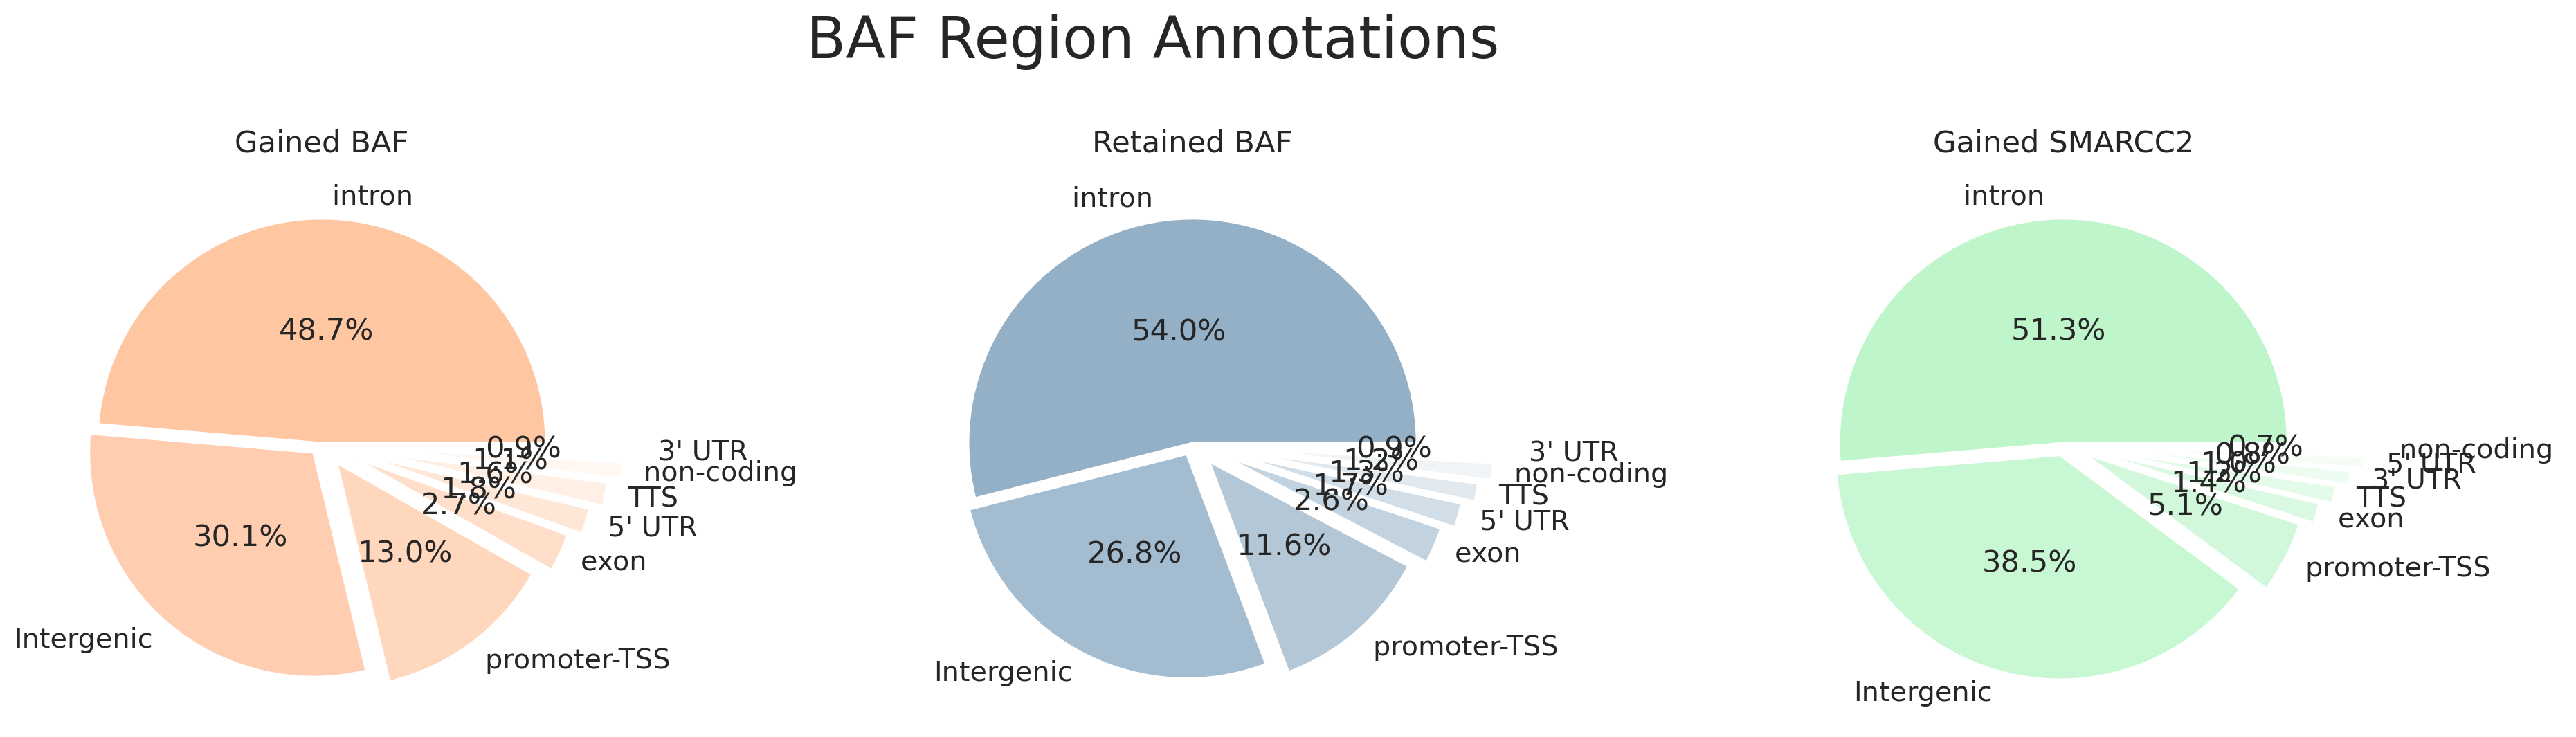

In [44]:
N = DF.groupby(["Set", "shortAnn"]).size().reset_index()
colorPalette = dict(zip(["gBAF", "rBAF","gSMA"], ["#FF8E47","#2A628F","#80ed99"]))
SetLabels = {
    "gBAF": "Gained BAF",
    "rBAF": "Retained BAF",
    "gSMA": "Gained SMARCC2"
}


sns.set(style="ticks", font_scale=1.3)

plt.rcParams["figure.dpi"] = 200


for s, c in colorPalette.items():
    cvals  = [0, 1]
    colors_ = [c,"#ffffff"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors_))
    colorPalette[s] = colors.LinearSegmentedColormap.from_list("", tuples)


fig = plt.figure(figsize=[23,6])
gs = gridspec.GridSpec(nrows=1, ncols=3)


plt.subplots_adjust(top=0.8)
for i,(s, c) in enumerate(colorPalette.items()):
    fig.add_subplot(gs[i])
    data = N[N["Set"] == f"{s}"].sort_values(0,ascending=False)
    colors_ = plt.get_cmap(c)(np.arange(8))
    colors_[:,-1] = np.linspace(0.5, 0, 8)
    patches, texts, autotexts = plt.pie(x=data[0], 
            autopct="%.1f%%", 
            explode=np.linspace(0,0.4, 8),#[0.1]*8, 
            labels=data["shortAnn"], 
            pctdistance=0.5, 
            colors=colors_)
    plt.title(SetLabels[s] );


fig.suptitle("BAF Region Annotations", fontsize=30)
fig.savefig("plot/baf.annot.pdf", bbox_inches="tight", pad_inches=1)



# Region Heatmaps
These are peak centric heatmaps where the intensity represent higher the read depth achived from the ChIP-seq experiments

In [26]:
import sys
sys.path.append("/home/ualtintas/bluegill/")
import bluegill.run as bgrun
import bluegill.plt as bgplt

import pickle

In [24]:
BED = {
    'gBAF' : 'data/chip/baf/gBAF.bed',
    'rBAF' : 'data/chip/baf/rBAF.bed',
    'gSMA' : 'data/chip/baf/gSMA.bed'
}
BED = bgrun.runBed(BED)

BWS = [
'chipseq_pipeline/results_hg38/bigwig/LNCaP_SMARCC2.genomecov.FPM.bw',
'chipseq_pipeline/results_hg38/bigwig/MR49F_SMARCC2.genomecov.FPM.bw',
'chipseq_pipeline/results_hg38/bigwig/LNCaP_BRG1.genomecov.FPM.bw',
'chipseq_pipeline/results_hg38/bigwig/MR49F_BRG1.genomecov.FPM.bw'
]

Nbins=200
h=3000

BED, samples = bgrun.runSignal(BED, BWS, "data/chip/bluegill/baf.heatmap.p",  Nbins=Nbins, h=h, nP=50)

0: LNCaP_SMARCC2.genomecov.FPM.bw :: 1: LNCaP_SMARCC2.genomecov.FPM.bw :: 2: LNCaP_SMARCC2.genomecov.FPM.bw :: 3: LNCaP_SMARCC2.genomecov.FPM.bw :: 4: LNCaP_SMARCC2.genomecov.FPM.bw :: 5: LNCaP_SMARCC2.genomecov.FPM.bw :: 6: LNCaP_SMARCC2.genomecov.FPM.bw :: 7: LNCaP_SMARCC2.genomecov.FPM.bw :: 8: LNCaP_SMARCC2.genomecov.FPM.bw :: 9: LNCaP_SMARCC2.genomecov.FPM.bw :: 10: LNCaP_SMARCC2.genomecov.FPM.bw :: 11: LNCaP_SMARCC2.genomecov.FPM.bw :: 12: LNCaP_SMARCC2.genomecov.FPM.bw :: 13: LNCaP_SMARCC2.genomecov.FPM.bw :: 14: LNCaP_SMARCC2.genomecov.FPM.bw :: 15: LNCaP_SMARCC2.genomecov.FPM.bw :: 16: LNCaP_SMARCC2.genomecov.FPM.bw :: 17: LNCaP_SMARCC2.genomecov.FPM.bw :: 18: LNCaP_SMARCC2.genomecov.FPM.bw :: 19: LNCaP_SMARCC2.genomecov.FPM.bw :: 20: LNCaP_SMARCC2.genomecov.FPM.bw :: 21: LNCaP_SMARCC2.genomecov.FPM.bw :: 22: LNCaP_SMARCC2.genomecov.FPM.bw :: 24: LNCaP_SMARCC2.genomecov.FPM.bw23: LNCaP_SMARCC2.genomecov.FPM.bw ::  :: 25: LNCaP_SMARCC2.genomecov.FPM.bw :: 26: LNCaP_SMARCC2.geno

/home/ualtintas/bluegill/bluegill/plt.py:159: UserWarning: Use the colorbar set_ticks() method instead.
  plt.yticks([])
/home/ualtintas/bluegill/bluegill/plt.py:159: UserWarning: Use the colorbar set_ticks() method instead.
  plt.yticks([])
/home/ualtintas/bluegill/bluegill/plt.py:159: UserWarning: Use the colorbar set_ticks() method instead.
  plt.yticks([])
/home/ualtintas/bluegill/bluegill/plt.py:159: UserWarning: Use the colorbar set_ticks() method instead.
  plt.yticks([])


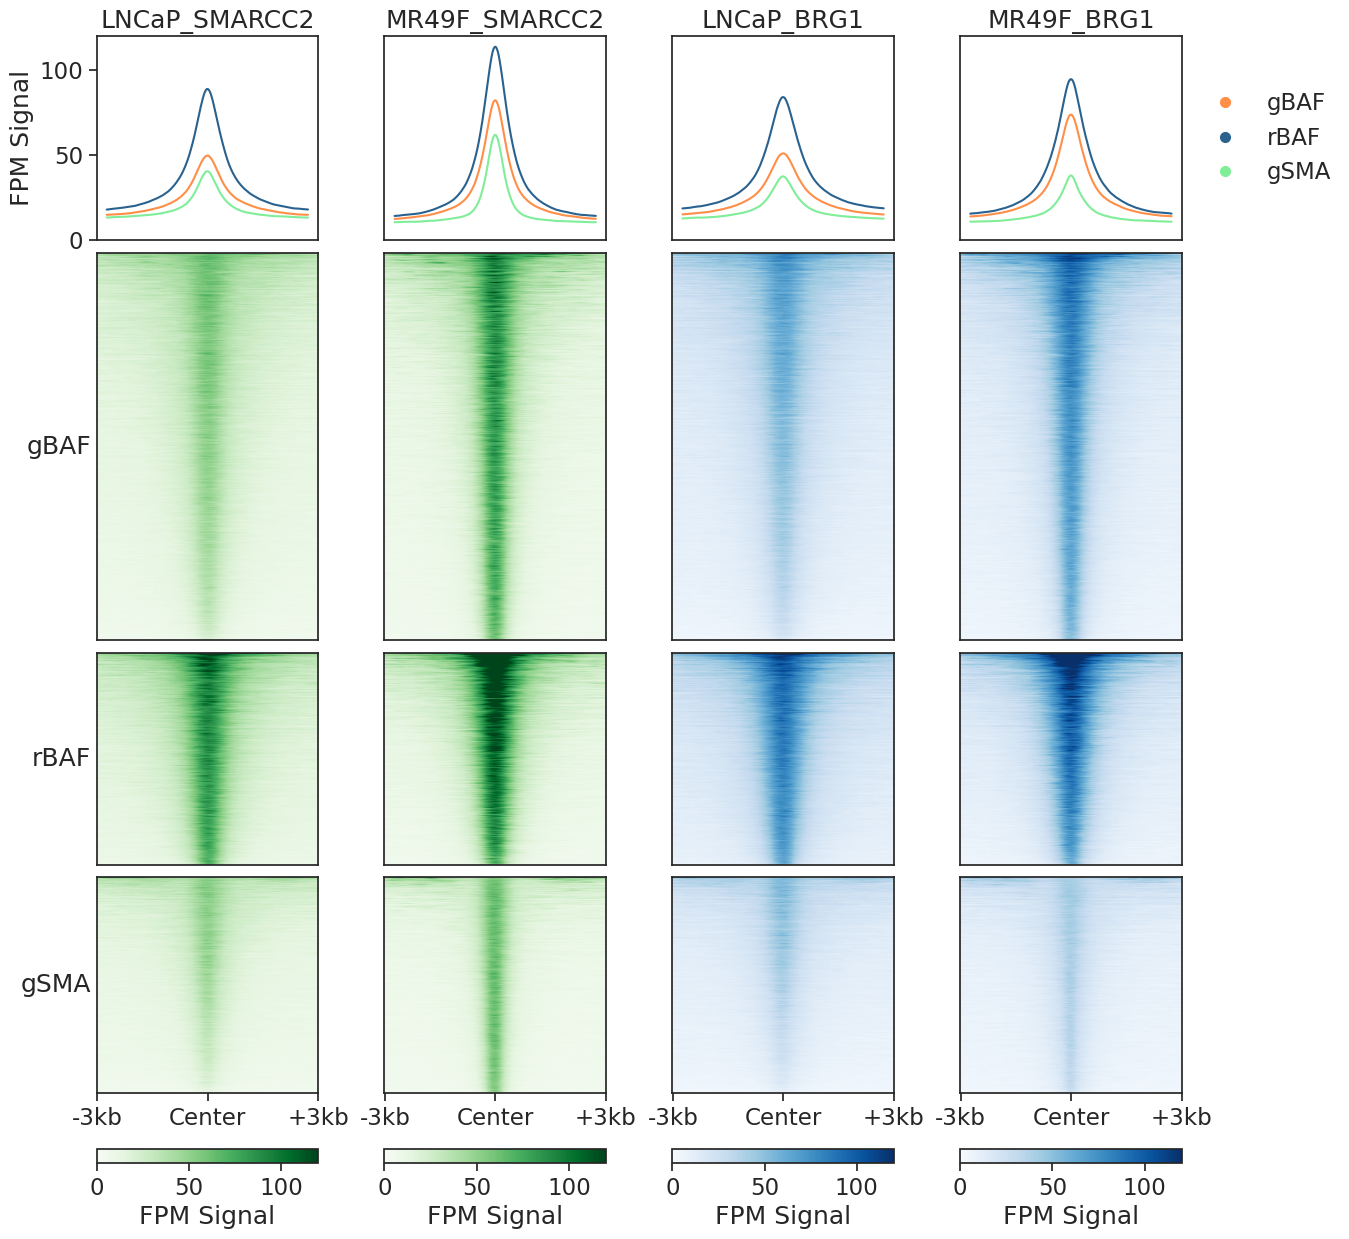

In [46]:

S = pickle.load(open("data/chip/bluegill/baf.heatmap.p","rb"))
N = bgrun.runTMM(S)

header = ['LNCaP_SMARCC2', 'MR49F_SMARCC2', 'LNCaP_BRG1', 'MR49F_BRG1']

palette = ["Greens", "Greens", "Blues","Blues"] 
sets = ['gBAF', "rBAF", 'gSMA']
colorPalette = dict(zip(["gBAF", "rBAF","gSMA"], ["#FF8E47","#2A628F","#80ed99"]))

sns.set(font_scale=1.5, style='ticks')

fig = bgplt.plotHeatmaps(
    N, BED,
    header, palette, sets, colorPalette,
    clab='FPM Signal', ylim=(0,120),vmin=0,vmax=120,
    h=h, dpi=100
)

fig.savefig("plot/baf.heatmap.pdf", bbox_inches="tight", pad_inches=1)

# Giggle Analysis

[Giggle](https://www.nature.com/articles/nmeth.4556) is a search engine that identify and rank the significance of genomic loci shared between query features and thousands of genome interval files. Thus, with large ChIP-seq datasets, we can see which factors are significant in the query loci. [Cistrome db ToolKit](http://dbtoolkit.cistrome.org/) provide a web-based tool to perform this.

In [35]:

giggle = pd.DataFrame()

for g in ["rBAF", "gBAF", "gSMA"]:
    tmp = pd.read_table(f"data/chip/baf.giggle/{g}.bed_result.csv", sep=",")
    tmp["Set"] = g
    giggle = pd.concat([giggle, tmp])
    
ratio = None

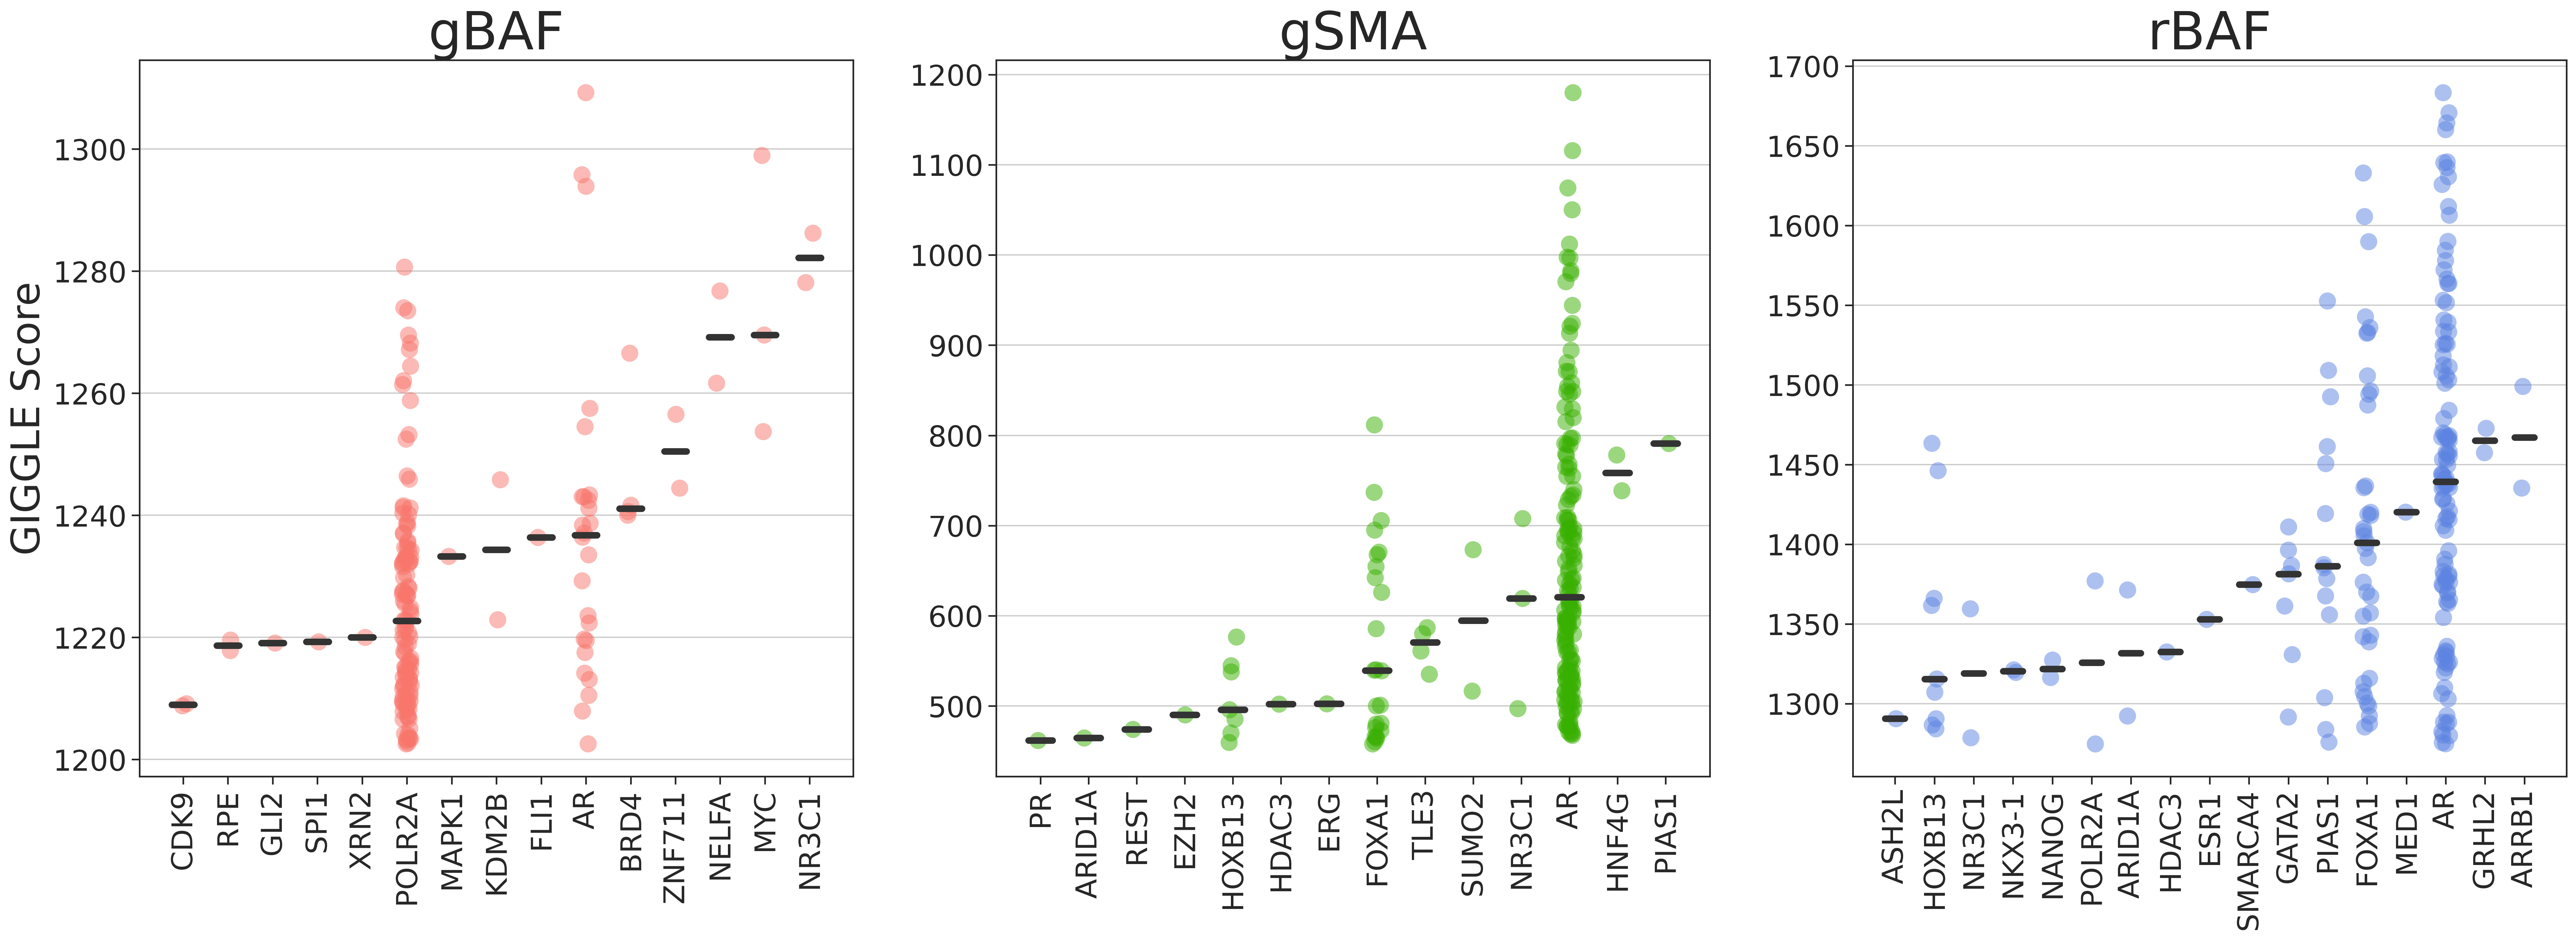

In [47]:

ratio = [giggle[giggle["Set"] == "PC3"].groupby("Factor").size().shape[0], 
         giggle[giggle["Set"] == "LNCaP"].groupby("Factor").size().shape[0]]


ratio = [giggle[giggle["Set"] == "gBAF"].groupby("Factor").size().shape[0], 
         giggle[giggle["Set"] == "rBAF"].groupby("Factor").size().shape[0]]
         #giggle[giggle["Set"] == "gSMARCC2"].groupby("Factor").size().shape[0]]

k=26
ratio = [1,1,1]

sns.set(font_scale=2, style="ticks")

plt.rc("font", family="Arial")

plt.rcParams["figure.dpi"] = 300

colorPalette = dict(zip(["gBAF", "gSMA", "rBAF"], ["#F8766C", "#38b000","#5D84E2"]))

fig = plt.figure(figsize=[33,10])
gs = gridspec.GridSpec(nrows=1, ncols=3,width_ratios=ratio)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

will_F = ['NR3C1', 'NELFA','MYC', 'FLI1','ZNF711','BRD4', 'MAPK1', 'KDM2B', 'AR', 'XRN2', 'GLI2', 'CDK7', 'SPI1', 'POLR2A', 'CDK9', 'ERG', 'RPE']
will_S = ['HNF4G', 'PIAS1', 'AR', 'TLE3', 'SUMO2', 'ERG', 'TEAD4', 'HDAC3', 'NR3C1', 'REST', 'FOXA1', 'EZH2', 'EHMT2', 'PR', 'HOXB13', 'ERF', 'ARID1A']
for i, set_ in enumerate(["gBAF", 'gSMA',"rBAF"]):
    

    ax = fig.add_subplot(gs[i])
    
    ax.yaxis.grid()

    data = giggle[giggle["Set"] == set_]
    if set_ == 'gBAF':
        data = data[data['Factor'].isin(will_F)]
    elif set_ == 'gSMA':
        data = data[data['Factor'].isin(will_S)]
    tfs = data.groupby("Factor").median().sort_values("GIGGLE_score", ascending=True)
    will = tfs[-k:].index
    
    
    med = data.set_index("Factor").loc[will, ].reset_index()

    

    sns.stripplot(x="Factor", y="GIGGLE_score", data=med, color=colorPalette[set_],alpha=0.5,size=13)
    plt.xlabel("")
    if i == 0:
        plt.ylabel("GIGGLE Score", fontsize=30)
        #plt.yticks(list(range(1500, 2000,100)), list(range(1500, 2000,100)))
    else:
        plt.ylabel("")
        #plt.yticks(list(range(900, 1900,200)), list(range(900, 1900,200)))
    plt.title(set_, fontsize=40)
    plt.xticks(rotation=90, ha="center", va="top")
    
    for j,(tf, median) in enumerate(tfs.iterrows()):
        plt.plot([j-0.25,j+0.25], [median]*2, c="#333333", lw=5,zorder=10)

    
fig.savefig("plot/baf.giggle.pdf", bbox_inches="tight", pad_inches=1)

# Motif Analysis

The known motifs can be located using [fimo](https://meme-suite.org/meme/doc/fimo.html). Curated motifs from [hocomoco](https://hocomoco11.autosome.org/).

In [53]:
%%bash

parallel  "bedtools getfasta -fi /groups/lackgrp/genomeAnnotations/hg38/hg38.fa -bed data/chip/baf/{}.bed -name > data/chip/baf/{}.fa"  ::: "rBAF" "gBAF" "gSMA"

source /home/ualtintas/miniconda/bin/activate meme
mememotifs=/groups/lackgrp/genomeAnnotations/motif-db/hocomoco/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme
parallel "fimo --o data/chip/baf.motif/{} -max-strand --parse-genomic-coord $mememotifs data/chip/baf/{}.fa"  ::: "rBAF" "gBAF" "gSMA"

Using motif +AHR_HUMAN.H11MO.0.B of width 9.
Using motif -AHR_HUMAN.H11MO.0.B of width 9.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.4884
Using motif +AIRE_HUMAN.H11MO.0.C of width 18.
Using motif -AIRE_HUMAN.H11MO.0.C of width 18.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.303
Using motif +ALX1_HUMAN.H11MO.0.B of width 12.
Using motif -ALX1_HUMAN.H11MO.0.B of width 12.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.597
Using motif +ANDR_HUMAN.H11MO.0.A of width 18.
Using motif -ANDR_HUMAN.H11MO.0.A of width 18.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.4724
Using motif +AP2A_HUMAN.H11MO.0.A of width 15.
Using motif -AP2A_HUMAN.H11MO.0.A of width 15.
Computing q-values.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec, lines, colors


In [2]:
DF = pd.DataFrame()

for s in ["rBAF","gBAF", "gSMA"]:
    tmp = pd.read_table(f"data/chip/baf.motif/{s}/fimo.tsv", comment="#")
    tmp["Factor"] = tmp["motif_id"].str.split("_", expand=True)[0]
    tmp["Set"] = s
    DF = pd.concat([DF, tmp])
    


mDF = DF.groupby(["Set", "Factor"], sort=False)["score"].max()
mDF = DF.groupby(["Set", "Factor"])["score"].mean().reset_index()
qDF = DF.groupby(["Set", "Factor"], sort=False)["q-value"].min().reset_index()

qDF["lq"] = np.log(qDF["q-value"])


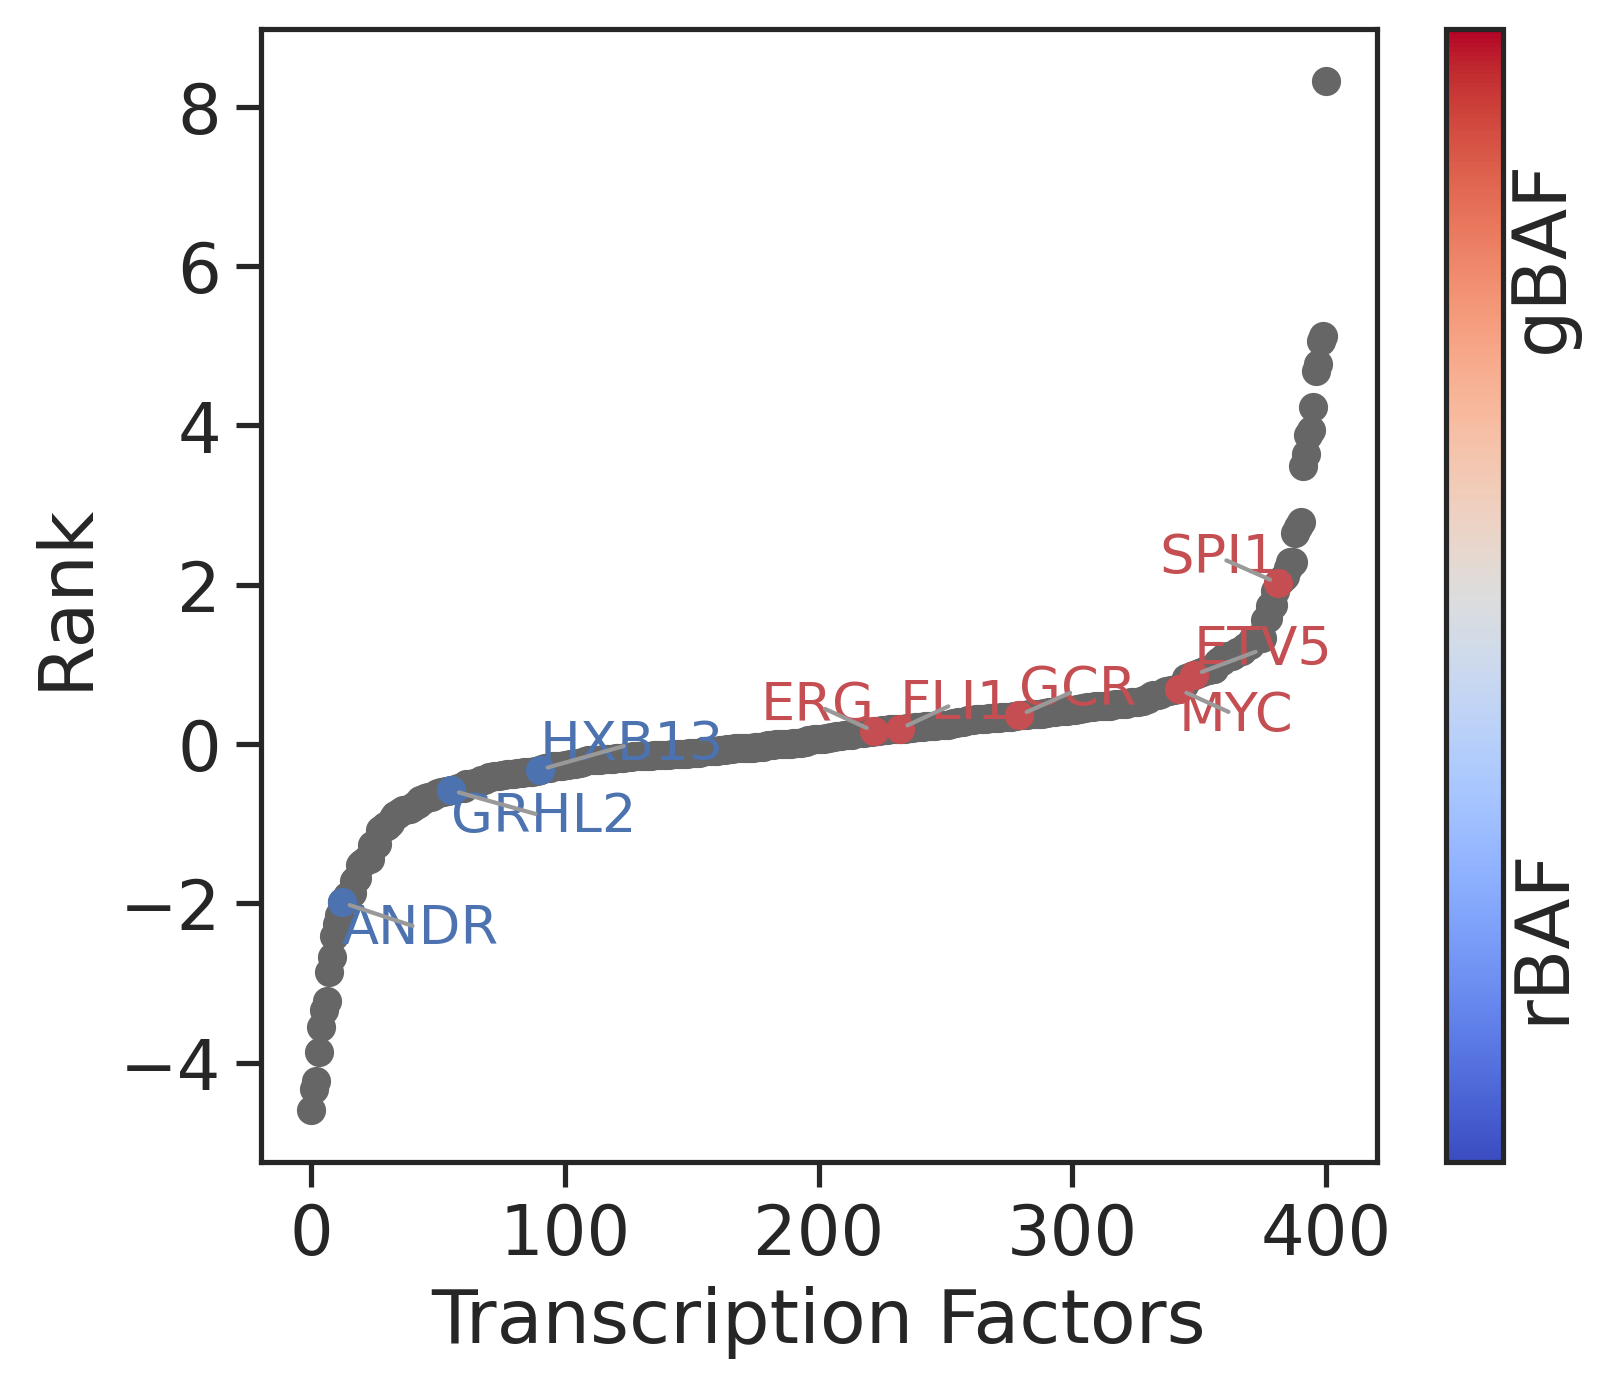

In [10]:




cvals  = [-4, 0, 8]
colors_ = ["#F8766C", "#FFFFFF", "#5D84E2"]
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors_))
cm = colors.LinearSegmentedColormap.from_list("", tuples)

sns.set(font_scale=1.5, style="ticks")
plt.rcParams["figure.dpi"] = 300
plt.rcParams["image.cmap"]  = "coolwarm" 


will_rbaf = ["HXB13", "GRHL2","ANDR"]
will_gbaf = ["SPI1","MYC","ETV5", "FLI1","GCR", "ERG"]

fig = plt.figure(figsize=[6,5])
q = qDF.pivot(index="Factor", columns="Set", values="lq")

tfs = np.array((q["gBAF"]-q["rBAF"]).index)
rnk = -np.array((q["gBAF"]-q["rBAF"]).to_list())

order = np.argsort(rnk)

tfss = tfs[order]
data = rnk[order]

ax = plt.scatter(range(401), data, c="#666666")

tfl = list(tfss)
texts = []
for w in will_rbaf:
    i = tfl.index(w)
    plt.scatter([i], [data[i]], c="b")
    texts.append(plt.text(i, data[i], tfss[i], fontsize=13, color="b", ha='center', va='center'))
    
for w in will_gbaf:
    i = tfl.index(w)
    plt.scatter([i], [data[i]], c="r")
    texts.append(plt.text(i, data[i], tfss[i], fontsize=13, color="r", ha='center', va='center'))
    

plt.xlabel("Transcription Factors")
plt.ylabel("Rank")

cbar = plt.colorbar(ax)
cbar.set_ticks([])
for j, lab in enumerate(["rBAF", "gBAF"]):
    
    cbar.ax.text(1.7,(3 * j + 1) / 5.0, lab, ha='center', va='center', rotation=90)
    
from adjustText import adjust_text
adjust_text(texts, force_points=0.2, force_text=0.2,
            expand_points=(1, 1), expand_text=(1, 1),
            arrowprops=dict(arrowstyle="-", color="#999999", lw=1))


fig.savefig("plot/baf.motif.pdf", bbox_inches="tight", pad_inches=1)

# Clinical ATAC
- PPCA: [TCGA](https://doi.org/10.1126/science.aav1898) ATAC-seq [data](https://gdc.cancer.gov/about-data/publications/ATACseq-AWG)

- CRPC, NEPC etc: [GSE156291](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE156291)

In [1]:
%%bash

mapchain=/groups/lackgrp/genomeAnnotations/hg38/liftOver/hg38ToHg19.over.chain

parallel  "liftOver data/chip/baf/{}.bed $mapchain data/chip/baf/{}.hg19.bed unMapped"  ::: "rBAF" "gBAF" "gSMA"

rm unMapped

Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates


In [1]:
import sys
sys.path.append("/home/ualtintas/bluegill/")
import bluegill.run as bgrun
import bluegill.plt as bgplt

import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
BED = {
    'gBAF' : 'data/chip/baf/gBAF.bed',
    'rBAF' : 'data/chip/baf/rBAF.bed',
    'gSMA' : 'data/chip/baf/gSMA.bed'
}
BED = bgrun.runBed(BED)
BED = BED[BED["Chr"].str.find("_") == -1].reset_index(drop=True)
BED = BED[BED["Chr"].str.find("chrM") == -1].reset_index(drop=True)
BED['L'] = BED['End'] - BED['Start']                                                            
                                                                                                 
sizes = pd.read_table("/groups/lackgrp/genomeAnnotations/hg19/hg19.chrom.sizes", names=["Chr", "Size"])
sizes = sizes[sizes["Chr"].str.find("_") == -1]
sizes = sizes[sizes["Chr"] != "chrM"]
sizes = sizes.reset_index(drop=True).set_index("Chr")

R = []
for Chr, row in sizes.iterrows():
    Size = row["Size"]
    centers = np.random.randint(1, Size, 1000)
    for c in centers:
        d = np.random.choice(BED["L"]) // 2
        if c-d < 1:
            s = 1
        else:
            s = c-d
        
        if c+d > Size:
            e = Size
        else:
            e = c+d
        R.append((Chr, s, e))

RND = pd.DataFrame(R, columns=["Chr", "Start", "End"])
RND["L"] = RND["End"] - RND["Start"]
RND = RND.sort_values(["Chr", "Start"]).reset_index(drop=True)
RND["Name"] = RND["Chr"] +":"+ RND["Start"].astype(str) +"-"+ RND["End"].astype(str) +".RND"

RND.to_csv("data/chip/baf/rnd.hg19.bed", sep="\t", index=False, header=False)
!bedtools intersect -v -a data/chip/baf/rnd.hg19.bed -b /groups/lackgrp/genomeAnnotations/hg19/hg19-blacklist.v2.bed > data/chip/baf/rnd.blk.hg19.bed


In [2]:
BED = {
    'gBAF' : 'data/chip/baf/gBAF.hg19.bed',
    'rBAF' : 'data/chip/baf/rBAF.hg19.bed',
    'gSMA' : 'data/chip/baf/gSMA.hg19.bed',
    'RND'  : 'data/chip/baf/rnd.blk.hg19.bed'
}
BED = bgrun.runBed(BED)


BWS = []
grp = []

path = "/groups/lackgrp/projects/req-bengul-swi/ATAC/atac_primarytumor/bw"
for sample in os.listdir(path):
    BWS.append(f"{path}/{sample}")
    grp.append('PPCA')

meta = pd.read_table("data/atac/GSE156291-meta.tsv")
path = "/groups/lackgrp/projects/req-bengul-swi/ATAC/GEO"
for i,(sample,tissue,gsm) in meta.iterrows():
    BWS.append(f"{path}/{gsm}_{sample}.rep1_treat_pileup.bw")
    grp.append(tissue)

#isin = ['/groups/lackgrp/projects/req-bengul-swi/ATAC/GEO/'+s for s in os.listdir('/groups/lackgrp/projects/req-bengul-swi/ATAC/GEO')]
#for b in BWS:
#    if b not in isin:
#        print(b)
    

In [6]:
Nbins=1
h=0

BED, samples = bgrun.runSignal(BED, BWS, "data/atac/clinical.p",  Nbins=Nbins, h=h, nP=50, igv=True)
BED.to_csv('data/atac/clinical.bed', sep='\t', index='False')

0: TCGA-PRAD_ZG-A9L1-01A.bw :: 1: TCGA-PRAD_ZG-A9L1-01A.bw :: 2: TCGA-PRAD_ZG-A9L1-01A.bw :: 3: TCGA-PRAD_ZG-A9L1-01A.bw :: 4: TCGA-PRAD_ZG-A9L1-01A.bw :: 5: TCGA-PRAD_ZG-A9L1-01A.bw :: 6: TCGA-PRAD_ZG-A9L1-01A.bw :: 7: TCGA-PRAD_ZG-A9L1-01A.bw :: 8: TCGA-PRAD_ZG-A9L1-01A.bw :: 9: TCGA-PRAD_ZG-A9L1-01A.bw :: 10: TCGA-PRAD_ZG-A9L1-01A.bw :: 11: TCGA-PRAD_ZG-A9L1-01A.bw :: 12: TCGA-PRAD_ZG-A9L1-01A.bw :: 13: TCGA-PRAD_ZG-A9L1-01A.bw :: 14: TCGA-PRAD_ZG-A9L1-01A.bw :: 15: TCGA-PRAD_ZG-A9L1-01A.bw :: 16: TCGA-PRAD_ZG-A9L1-01A.bw :: 17: TCGA-PRAD_ZG-A9L1-01A.bw :: 18: TCGA-PRAD_ZG-A9L1-01A.bw :: 19: TCGA-PRAD_ZG-A9L1-01A.bw :: 20: TCGA-PRAD_ZG-A9L1-01A.bw :: 21: TCGA-PRAD_ZG-A9L1-01A.bw :: 22: TCGA-PRAD_ZG-A9L1-01A.bw :: 23: TCGA-PRAD_ZG-A9L1-01A.bw :: 24: TCGA-PRAD_ZG-A9L1-01A.bw :: 25: TCGA-PRAD_ZG-A9L1-01A.bw :: 26: TCGA-PRAD_ZG-A9L1-01A.bw :: 28: TCGA-PRAD_ZG-A9L1-01A.bw27: TCGA-PRAD_ZG-A9L1-01A.bw ::  :: 29: TCGA-PRAD_ZG-A9L1-01A.bw :: 30: TCGA-PRAD_ZG-A9L1-01A.bw :: 31: TCGA-PRAD_ZG-A

In [3]:
BED = pd.read_table('data/atac/clinical.bed')

S = pickle.load(open("data/atac/clinical.p","rb"))
N = bgrun.runTMM(S)
T = N.mean(2)
w = np.array(BED['End'] - BED['Start'])
t = T / w[:,None]
T = ((T / w[:,None]) / t.sum(0)) * 10**6
idx = T.std(1) != 0
F = T[idx,:]
Z = ( F - F.mean(1)[:,None] ) / F.std(1)[:,None]

bed = BED.iloc[idx,:]


In [4]:
#df = pd.DataFrame(N.mean(2)[idx,:], columns=grp, index=bed['Set']).reset_index().groupby('Set').mean().stack().reset_index()
df = pd.DataFrame(F, columns=grp, index=bed['Set']).reset_index().groupby('Set').mean().stack().reset_index()
df

,Set,level_1,0
0,RND,PPCA,8.769380
1,RND,PPCA,6.010158
2,RND,PPCA,9.007291
3,RND,PPCA,5.252771
4,RND,PPCA,8.154148
...,...,...,...
183,rBAF,CRPC,19.914095
184,rBAF,NEPC,17.341928
185,rBAF,NEGI,17.590916
186,rBAF,NEGI,18.174903


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PPCA_rBAF v.s. PPCA_gBAF: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.982e-08 U_stat=0.000e+00
CRPC_rBAF v.s. CRPC_gBAF: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.299e-02 U_stat=0.000e+00
PPCA_rBAF v.s. CRPC_rBAF: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.134e-02 U_stat=2.400e+01
PPCA_gBAF v.s. CRPC_gBAF: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.526e-05 U_stat=0.000e+00
PPCA_RND v.s. CRPC_RND: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.800e-04 U_stat=1.330e+02
PPCA_gSMA v.s. CRPC_gSMA: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.800e+01


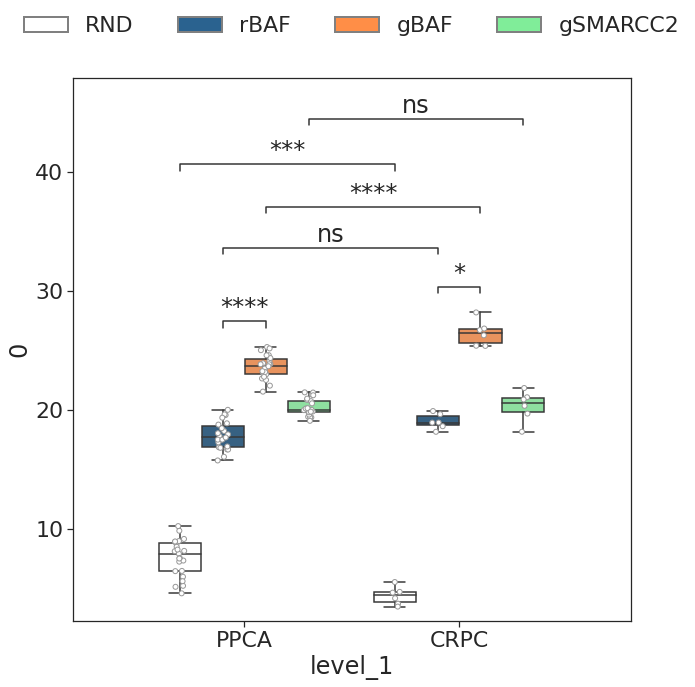

In [5]:

fig = plt.figure(figsize=[10,10])
sns.set(style='ticks', font_scale=2)

ax1 = sns.stripplot(data=df, 
              x="level_1", y=0, hue="Set", 
              hue_order=["RND", "rBAF", "gBAF", "gSMA"], order=["PPCA", "CRPC"],
              palette=["white","white","white"], dodge=True, linewidth=1,edgecolor="gray")


ax = sns.boxplot(data=df, 
            x="level_1", y=0, hue="Set", 
            hue_order=["RND", "rBAF", "gBAF", "gSMA"], order=["PPCA", "CRPC"], palette=["#FFFFFF", "#2A628F","#FF8E47","#80ed99"])

plt.legend([], frameon=False)


from statannot import add_stat_annotation


boxPairs = [
    (("PPCA", "rBAF"), ("CRPC", "rBAF")),
    (("PPCA", "gBAF"), ("CRPC", "gBAF")),
	(("PPCA", "rBAF"), ("PPCA", "gBAF")),
	(("CRPC", "rBAF"), ("CRPC", "gBAF")),
    (("PPCA", "RND" ), ("CRPC", "RND" )), 
    (("PPCA", "gSMA"), ("CRPC", "gSMA"))
    ]

add_stat_annotation(data=df, 
                    x="level_1", y=0, hue="Set", 
                    hue_order=["RND", "rBAF", "gBAF", "gSMA"], order=["PPCA", "CRPC"],  box_pairs=boxPairs,ax=ax,
                    test='Mann-Whitney', loc='inside', verbose=2)


colorPalette = dict(zip(["RND", "rBAF", "gBAF", "gSMARCC2"], ["#FFFFFF", "#2A628F","#FF8E47","#80ed99"]))

patchs = [mpatches.Patch(facecolor=colorPalette[nc], label=nc,linewidth=2, edgecolor="gray") for nc in colorPalette]

plt.legend(handles=patchs,loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=4,frameon=False)


fig.savefig("plot/baf.clinical.pdf", bbox_inches="tight", pad_inches=1)